# Computation of hw indices by monthly hw events for NOAA Stations

Author: Martin Pavez

Creation: Jannuary 2025

Steps:
1. We read the cleaned data produced by notebook 01.
2. We compute the indices HWN, HWF, HWD, HWM, HWA for each year and each station.
3. We save the results in order to be used in the next notebooks.

In [1]:
import sys
import os

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import norm
from scipy.optimize import curve_fit

import pickle


import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) # Suppress specific RuntimeWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
os.chdir("../")
# change working directory to project's root path
print(os.getcwd())

c:\Users\marti\Desktop\data\hw_extra


# Parameters


In [4]:
METADATA_PATH_AND_FILENAME = 'data/local_data/NOAA/stations.parquet'
TEMP_DATA_PATH = 'data/local_data/NOAA/original'
CLEANED_DATA_PATH = 'data/local_data/NOAA/cleaned_2/'
MY_FUNCTIONS_PATH = 'hugo/functions/'

In [5]:
# Add the folder to the Python path
folder_path = os.path.abspath(MY_FUNCTIONS_PATH)
sys.path.insert(0, folder_path)

from HWCompAndStats import (
    HW_statistics,
    HW_indices_summary,
    HW_stats_of_indices,
    plot_stats_of_hwi
)

# Reading data
Let us assume we compute over Quinta Normal (station id = 330020)

In [8]:
# Reading raw data of selected stations

### stations are already selected
statlist_10 = ['USC00040983', 'USC00041194', 'USC00041253', 'USC00040741', 'USC00040212', 'USC00040931', 'USC00041277', 'USC00041244', 'USC00040693', 'USC00040449']
stations = pd.DataFrame(index = statlist_10)

statlist = statlist_10.copy()
station_data_to_read = {}
stations_data = {}
for stat in statlist:
    stations_data[stat] = pd.read_parquet(CLEANED_DATA_PATH + f'Stat_{stat}.parquet')

stations = pd.DataFrame(index = statlist)

In [9]:
for stat in statlist:
    stations_data[stat] =  stations_data[stat].dropna()

np.sum(np.isnan(stations_data[stat]['max_temp']))

0

# Heatwave definitions

Let us assume we are working over the MeteoChile's definition.

In [10]:
# MeteoChile
HWDef = {'Tind_type': 'max_temp',
        'Tcrit_dict': {'meas': 'perc',
                        'perc': 90,
                        'adj': 'adj',
                        'set': '',
                        'Tadd': 0,
                        'hist_data_temp': 'max_temp'
                        },
        'Nd': 3}

HWDef_dict = {}
HWDef_dict['CIMIS'] = HWDef

start_year = 1971
end_year = 2023


ref_period = {}
ref_period['CDA'] = [1981, 2010] #ref period due to data availability in california

# The computation of monthly indices for a given station

 Heatwave intensity and frequency measures are considered. Let $HW$ denote the set of heatwave events in a given year. The following indices for heatwaves will be used, based in \cite{perkins2013measurement}:

1) HWN: yearly number of heat waves.
$$
HWN = \lvert HW \rvert = \sum_{W \in HW} 1 .
$$
2) HWF: yearly number of days included in HW events. 
$$
HWF = \sum_{W \in HW} \lvert W \rvert = \sum_{W \in HW} \sum_{w \in W} 1 . 
$$
3) HWD: Maximum duration (in days) of the longest heat wave event in a given year. 
$$
HWD = \max \left\{ \lvert W \rvert ; \ W \in HWD \right\}
$$
4) HWM: average magnitude of all heat waves during a year.
$$
HWM = \frac{1}{HWF} 
\sum_{W \in HWD} \sum_{w \in W} T_{\operatorname{m}} (w) - T_{\operatorname{c}} (w)
%\sum_{
%\begin{matrix}
%d \in hw \\
%hw \text{ is a heatwave}
%\end{matrix}} T_{d, max} - T_{d, threshold}
$$
5) HWA: the peak daily value of the hottest heatwave event. 
$$
HWA =  \max \left\{ T_{\operatorname{m}}(w) - T_{\operatorname{c}}(w) \ \left\rvert  \ w \in \bigcup_{W \in HWD} W \right.\right\}
$$

Note that HWN and HWF measure annual frequency of heatwaves, while HWD, HWM, and HWA measure annual intensity.
Finally, as a remark, note that these definitions depend on the choice of heatwave definition. 

# What if the indices become monthly?

In [13]:
data = stations_data['USC00040983']
print(f'nans={np.sum(np.isnan(data))}')

start_year = 1971
end_year = 2023

hws = []
for stat in statlist:
    data = stations_data[stat]
    hw1 = HW_statistics(data, start_year, end_year)
    _, _, heatwaves = hw1.HW_funs(HWDef['Tind_type'], HWDef['Tcrit_dict'], HWDef['Nd'], 1980, 2010)
    hws.append(heatwaves)

nans=max_temp    0
dtype: int64


In [15]:
def HWI(heatwaves, period_window, hwis, period_type = 'year'):
    start_year = period_window[0]
    end_year = period_window[1]
    if period_type=='year':
        index = range(start_year, end_year+1)
    elif period_type == 'month':
        date_range = pd.date_range(start=f'{start_year}-01-01', end=f'{end_year}-12-31', freq='M')
        index = [(date.year, date.month) for date in date_range]
    if isinstance(hwis, str):
        hwis = [hwis]
    hw_period_stats = pd.DataFrame(columns=hwis, index=index)
    for year_to_analyze in range(start_year, end_year+1):
        hw_year = heatwaves[heatwaves['start'].dt.year == year_to_analyze] ## Arbitrarily we decide start as belonging month
        if period_type == 'month':
            for month_to_analyze in range(1,13):
                hw_month = hw_year[hw_year['start'].dt.month == month_to_analyze]
                for hwi in hwis:
                    if hwi == 'HWN':
                        hwn = len(hw_month)
                        if np.isnan(hwn):
                            hw_period_stats['HWN'][(year_to_analyze, month_to_analyze)] = 0.0
                        else:
                            hw_period_stats['HWN'][(year_to_analyze, month_to_analyze)] = hwn
                    elif hwi == 'HWF':
                        hwf = np.sum(hw_month['duration'])
                        if np.isnan(hwn):
                            hw_period_stats['HWF'][(year_to_analyze, month_to_analyze)] = 0.0
                        else:
                            hw_period_stats['HWF'][(year_to_analyze, month_to_analyze)] = hwf
                    elif hwi == 'HWD':
                        hwd = np.max(hw_month['duration'])
                        if np.isnan(hwd):
                            hw_period_stats['HWD'][(year_to_analyze, month_to_analyze)] = 0.0
                        else:
                            hw_period_stats['HWD'][(year_to_analyze, month_to_analyze)] = hwd
                    elif hwi == 'HWM':
                        hwm = np.sum(np.array(hw_month['duration'], dtype=float)*np.array(hw_month['magnitude'], dtype=float))/np.sum(np.array(hw_month['duration'], dtype=float))
                        if np.isnan(hwm):
                            hw_period_stats['HWM'][(year_to_analyze, month_to_analyze)] = 0.0
                        else:
                            hw_period_stats['HWM'][(year_to_analyze, month_to_analyze)] = hwm
                    elif hwi == 'HWA':
                        hwa = np.max(hw_month['max_magn'])
                        if np.isnan(hwm):
                            hw_period_stats['HWA'][(year_to_analyze, month_to_analyze)] = 0.0
                        else:
                            hw_period_stats['HWA'][(year_to_analyze, month_to_analyze)] = hwa

        else:
            hw_period_stats['HWN'][year_to_analyze] = len(hw_year)
            hw_period_stats['HWF'][year_to_analyze] = np.sum(hw_year['duration'])
            hw_period_stats['HWD'][year_to_analyze] = np.max(hw_year['duration'])
            if np.isnan(hw_period_stats['HWD'][year_to_analyze]): #if a year does not have any heatwave event, then the duration is set to be 0. 
                hw_period_stats['HWD'][year_to_analyze] = 0.0
            hw_period_stats['HWM'][year_to_analyze] = np.sum(np.array(hw_year['duration'], dtype=float)*np.array(hw_year['magnitude'], dtype=float))/np.sum(np.array(hw_year['duration'], dtype=float))
            if np.isnan(hw_period_stats['HWM'][year_to_analyze]): #if a year does not have any heatwave event, then the duration is set to be 0. 
                hw_period_stats['HWM'][year_to_analyze] = 0.0
            hw_period_stats['HWA'][year_to_analyze] = np.max(hw_year['max_magn'])
            if np.isnan(hw_period_stats['HWA'][year_to_analyze]): #if a year does not have any heatwave event, then the duration is set to be 0. 
                hw_period_stats['HWA'][year_to_analyze] = 0.0
    if period_type == 'month':
        new_index = [pd.Period(year=i[0], month=i[1], freq='M') for i in list(hw_period_stats.index)]
        hw_period_stats.index = new_index

    return hw_period_stats

hwi = ['HWN', 'HWF', 'HWD', 'HWM', 'HWA']
period_window = [start_year, end_year]
#hwis = HWI(heatwaves, period_window, hwi, period_type = 'year')
#print(hwis)

for i in range(len(hws)):
    hwis = HWI(hws[i], period_window, hwi, period_type = 'month')
    hwis.index.name = "Date"
    hwis.to_csv(f"data/local_data/monthly/HWs_{statlist[i]}.csv")



In [12]:
hwis.to_csv("HWs_47.csv")

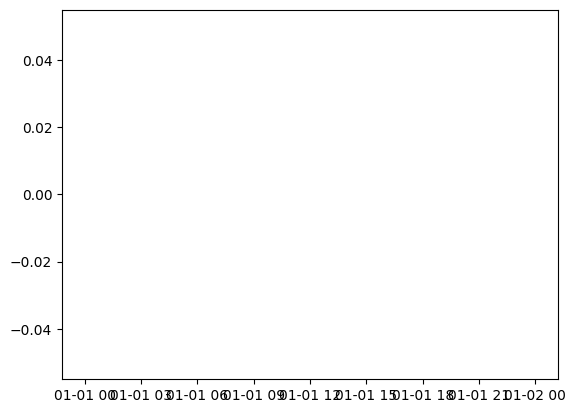

In [97]:
plt.plot(pd.Series(hwis['HWF'], index = hwis['HWF'].index.to_timestamp()))

In [57]:
year_to_analyze = 2022
hw_year = heatwaves[heatwaves['start'].dt.year == year_to_analyze]
print(hw_year)

month_to_analyze = 2
monthly_hw = hw_year[hw_year['start'].dt.month == month_to_analyze]
print(monthly_hw)
print(f'monthly hwi = {len(monthly_hw)}')

        start        end  duration  mean_temp  min_temp  max_temp   date_max  \
13 2022-12-10 2022-12-13         4  33.650000      32.1      35.4 2022-12-11   
14 2022-12-06 2022-12-08         3  32.600000      31.7      33.9 2022-12-06   
15 2022-11-21 2022-11-23         3  31.800000      31.3      32.5 2022-11-22   
16 2022-11-15 2022-11-18         4  31.525000      30.9      33.0 2022-11-15   
17 2022-10-31 2022-11-02         3  30.566667      29.3      32.0 2022-11-01   
18 2022-10-14 2022-10-16         3  27.733333      27.1      28.9 2022-10-15   
19 2022-09-02 2022-09-06         5  25.960000      22.9      28.6 2022-09-05   
20 2022-08-19 2022-08-21         3  24.700000      22.8      26.1 2022-08-19   
21 2022-04-04 2022-04-08         5  29.200000      28.4      30.1 2022-04-05   
22 2022-02-16 2022-02-18         3  32.466667      31.7      33.7 2022-02-17   

    magnitude  max_magn  
13   1.813866  3.588882  
14   1.011224  2.369965  
15   1.246061  1.945665  
16   1.421656  

# just for taking some ideas from this block...

In [ ]:


hw1 = HW_statistics(data, start_year, end_year)

_, _, heatwaves = hw1.HW_funs(HWDef['Tind_type'], HWDef['Tcrit_dict'], HWDef['Nd'], year_window[yw][0], year_window[yw][1])




def HW_indices_by_period(hw1, HWDef, start_year, end_year, period_window, period_type = 'year'):
    #this function is for a single HW definition and for a single station
    hw_stats_by_year = {}
    for yw in list(period_window.keys()): #range(1, len(year_window)+1):
        #hw_period_stats = {}
        _, _, heatwaves = hw1.HW_funs(HWDef['Tind_type'], HWDef['Tcrit_dict'], HWDef['Nd'], year_window[yw][0], year_window[yw][1])

        if period_type=='year':
            index = range(start_year, end_year+1)
        elif period_type == 'month':
            date_range = pd.date_range(start=f'{yw[0]}-01-01', end=f'{yw[1]}-12-31', freq='M')
            index = [(date.year, date.month) for date in date_range]

        hw_period_stats = pd.DataFrame(columns=['HWN', 'HWF', 'HWD', 'HWM', 'HWA'], index=index)

        for year_to_analyze in range(start_year, end_year+1):
            if period_type == 'year':
                hw_year = heatwaves[heatwaves['start'].dt.year == year_to_analyze]
                hw_period_stats['HWN'][year_to_analyze] = len(hw_year)
                hw_period_stats['HWF'][year_to_analyze] = np.sum(hw_year['duration'])
                hw_period_stats['HWD'][year_to_analyze] = np.max(hw_year['duration'])
                if np.isnan(hw_period_stats['HWD'][year_to_analyze]): #if a year does not have any heatwave event, then the duration is set to be 0. 
                    hw_period_stats['HWD'][year_to_analyze] = 0.0
                hw_period_stats['HWM'][year_to_analyze] = np.sum(np.array(hw_year['duration'], dtype=float)*np.array(hw_year['magnitude'], dtype=float))/np.sum(np.array(hw_year['duration'], dtype=float))
                if np.isnan(hw_period_stats['HWM'][year_to_analyze]): #if a year does not have any heatwave event, then the duration is set to be 0. 
                    hw_period_stats['HWM'][year_to_analyze] = 0.0
                hw_period_stats['HWA'][year_to_analyze] = np.max(hw_year['max_magn'])
                if np.isnan(hw_period_stats['HWA'][year_to_analyze]): #if a year does not have any heatwave event, then the duration is set to be 0. 
                    hw_period_stats['HWA'][year_to_analyze] = 0.0
            elif period_type == 'month':
                for month_to_analyze in range()
        hw_stats_by_year[yw] = hw_period_stats

    return hw_stats_by_year